In [28]:
!pip install torch torchvision transformers pandas pillow

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image, ImageDraw
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [30]:
# Create a directory to store the images
if not os.path.exists('synthetic_data/images'):
    os.makedirs('synthetic_data/images')

In [31]:
# Function to generate random images
def generate_image(color, shape, img_path):
    img = Image.new('RGB', (224, 224), color=(255, 255, 255))  # White background for contrast
    draw = ImageDraw.Draw(img)
    if shape == 'circle':
        # Proper bounding box for a perfect circle
        draw.ellipse((50, 50, 174, 174), fill=color, outline="black", width=3)
    elif shape == 'square':
        draw.rectangle((50, 50, 174, 174), fill=color, outline="black", width=3)
    img.save(img_path)

In [32]:
# Generate a CSV with image paths, more descriptive text, and correct labels
def create_synthetic_data(num_samples):
    data = []
    colors = ['red', 'green', 'blue', 'yellow']
    shapes = ['circle', 'square']

    for i in range(num_samples):
        color = random.choice(colors)
        shape = random.choice(shapes)

        # Ensure that the label corresponds to the shape correctly
        label = 0 if shape == 'circle' else 1  # Label 0 for circle, 1 for square

        img_path = f'synthetic_data/images/img_{i}.png'
        generate_image(color=color, shape=shape, img_path=img_path)

        # Make sure the text description is consistent with the generated shape
        text_description = f"This is a {color} {shape}. The shape is very {random.choice(['large', 'small'])}, and the color is {random.choice(['bright', 'dull'])}. It has a {shape} outline."
        data.append([img_path, text_description, label])

    # Save the dataset to CSV
    df = pd.DataFrame(data, columns=['image', 'text', 'label'])
    df.to_csv('synthetic_data/data.csv', index=False)


In [33]:
# Generate 100 synthetic samples
create_synthetic_data(100)

In [34]:
# Custom Dataset to handle both images and text
class MultimodalDataset(Dataset):
    def __init__(self, csv_file, tokenizer, transform=None):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        text = self.data.iloc[idx, 1]
        text_inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True)

        label = torch.tensor(int(self.data.iloc[idx, 2]))

        return image, text_inputs['input_ids'].squeeze(), text_inputs['attention_mask'].squeeze(), label


In [35]:
# Define the multimodal model
class MultimodalModel(nn.Module):
    def __init__(self, num_labels):
        super(MultimodalModel, self).__init__()
        # Pretrained CNN for images (ResNet18)
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 512)

        # Pretrained BERT for text
        self.text_model = BertModel.from_pretrained('bert-base-uncased')

        # Final classification layer
        self.fc = nn.Linear(512 + 768, num_labels)

    def forward(self, image, input_ids, attention_mask):
        # Image features
        img_features = self.image_model(image)

        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output

        # Concatenate the two modalities
        combined_features = torch.cat((img_features, text_features), dim=1)

        # Final classification
        output = self.fc(combined_features)
        return output

In [36]:
# Training parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 5
num_labels = 2  # Circle vs Square

# Tokenizer for text (BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:

# Load the full dataset
dataset = MultimodalDataset(csv_file='synthetic_data/data.csv', tokenizer=tokenizer, transform=transform)



In [38]:
# Split into training and testing datasets (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [39]:
# Initialize the model
model = MultimodalModel(num_labels=num_labels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, input_ids, attention_masks, labels in train_loader:
        images, input_ids, attention_masks, labels = images.to(device), input_ids.to(device), attention_masks.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_masks)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')



Epoch [1/5], Loss: 0.3984122809721157
Epoch [2/5], Loss: 0.0016011580126360058
Epoch [3/5], Loss: 0.00025182991794281406
Epoch [4/5], Loss: 6.4396015670809e-05
Epoch [5/5], Loss: 1.0552430808274949e-05


In [41]:

# Testing/Evaluation phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, input_ids, attention_masks, labels in test_loader:
        images, input_ids, attention_masks, labels = images.to(device), input_ids.to(device), attention_masks.to(device), labels.to(device)

        outputs = model(images, input_ids, attention_masks)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and print classification report
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['circle', 'square']))

Accuracy on test set: 100.00%
Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00         9
      square       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Accuracy on test set: 100.00%
ROC-AUC Score: 1.00
Confusion Matrix:
[[ 9  0]
 [ 0 11]]


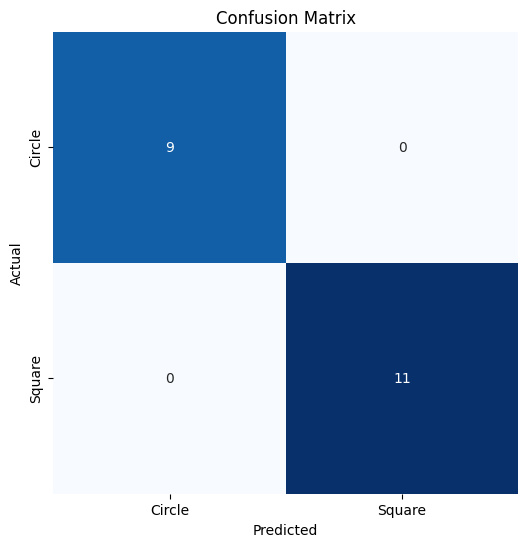

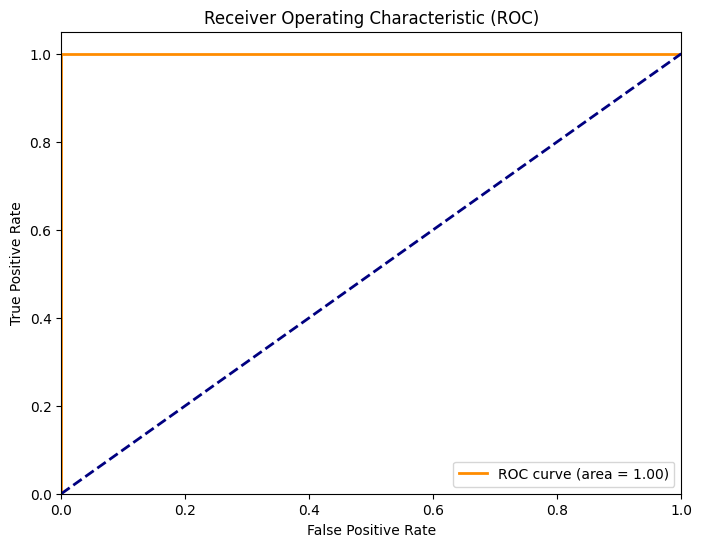

In [42]:
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, input_ids, attention_masks, labels in test_loader:
            images, input_ids, attention_masks, labels = images.to(device), input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(images, input_ids, attention_masks)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f'ROC-AUC Score: {roc_auc:.2f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Circle', 'Square'], yticklabels=['Circle', 'Square'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Example of how to run the evaluation:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_model(model, test_loader, device)
